Subtask B: Verifiable factual claims detection: Given a tweet, predict whether it contains a verifiable factual claim. This is a binary task with two labels: Yes and No. This is a classification task

In [112]:
import pandas as pd
import numpy as np
import json
import nltk
from nltk import ngrams
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
import re
import spacy

# Load Lemmatizer
nlp = spacy.load("en_core_web_sm")

# Load Stopwords
nltk.download('stopwords')
cachedStopWords = list(set(stopwords.words("english")))



# a)
# Twitter Datasets
df_worthy_train = pd.read_csv("data/1b/CT22_english_1B_claim_train.tsv", sep='\t')
df_worthy_test = pd.read_csv("data/1b/CT22_english_1B_claim_dev_test.tsv", sep='\t')

# Top 3000 most commonly used english words + covid related medical terms (used as vocabulary for the vectorization process)
topwords = pd.read_csv('words.txt', sep=" ", header=None).values[:,0]

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\minh\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


### Emoji Removal

In [113]:
# Function to remove emojies when using the lemmatizer
#https://poopcode.com/how-to-remove-emoji-from-text-in-python/
def remove_emoji(string):
    emoji_pattern = re.compile("["
                               u"\U0001F600-\U0001F64F"  # emoticons
                               u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                               u"\U0001F680-\U0001F6FF"  # transport & map symbols
                               u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                               u"\U00002500-\U00002BEF"  # chinese char
                               u"\U00002702-\U000027B0"
                               u"\U00002702-\U000027B0"
                               u"\U000024C2-\U0001F251"
                               u"\U0001f926-\U0001f937"
                               u"\U00010000-\U0010ffff"
                               u"\u2640-\u2642"
                               u"\u2600-\u2B55"
                               u"\u200d"
                               u"\u23cf"
                               u"\u23e9"
                               u"\u231a"
                               u"\ufe0f"  # dingbats
                               u"\u3030"
                               "]+", flags=re.UNICODE)
    return emoji_pattern.sub(r'', string)

### Custom Tokenizer

In [114]:
def tokenize_text(text, method="stopwords"):
    
    # Remove hyperlinks
    text = re.sub(r'http\S+', '', text)
    
    # Split sentence into words
    tokens = []
    for token in ngrams(text.split(), 1):
        word = re.sub(r',', '', token[0]) #Remove commas
        word = re.sub(r'[\!\.\:]$', '', word) #Remove (.!:) at the end of tokens
        word = re.sub(r'#', '', word) #Remove hashtags (not the text)
        if word == "—": continue #Ignore dash
        if word.find("@") != -1: continue #Ignore tags
        tokens.append(word)
    tokens

    # List comprehension to remove stopwords
    if method != "default":
        tokens = [x for x in tokens if x not in cachedStopWords]

    # Perform stemming
    if method == "stemming":
        ps = PorterStemmer()
        tokens = [ps.stem(x) for x in tokens]

    # Perform lemmatization
    if method == "lemmatizer":
        # Remove emojies due to lemmatizer not handling them well
        tokens = [x for x in tokens if remove_emoji(x) != ""]
        text = " ".join(tokens)
        doc = nlp(text)
        tokens = [token.lemma_ for token in doc]

    return tokens

In [115]:
def tokenize_normal(text):
    return tokenize_text(text, method="default")

def tokenize_stopwords(text):
    return tokenize_text(text, method="stopwords")

def tokenize_stemming(text):
    return tokenize_text(text, method="stemming")

def tokenize_lemmatizer(text):
    return tokenize_text(text, method="lemmatizer")

In [116]:
def tokenize_df(df, text_col, method="default"):
    article_tokens = []
    for i in range(len(df)):
        text = df.iloc[i][text_col].lower()
        article_tokens.append(tokenize_text(text, method))
    df["tokens"] = article_tokens

In [117]:
tokenize_df(df_worthy_train, "tweet_text", "lemmatizer")
tokenize_df(df_worthy_test, "tweet_text", "lemmatizer")

In [118]:
print(df_worthy_train["tokens"][0], "\n")
print(df_worthy_test["tokens"][0])

['india', "'s", 'gift', '100000', 'covid-19', 'vaccine', 'arrive', 'barbado', 'early', 'today', 'special', 'moment', 'barbadian', 'want', 'thank', 'prime', 'minister', 'modi', 'quick', 'decisive', 'magnanimous', 'action', 'allow', 'we', 'beneficiary', 'vaccine'] 

['senate', 'pass', 'covid', 'relief', '$', '1400', 'relief', 'check', 'fund', 'vaccine', 'money', 'reopen', 'school', 'food', 'unemployment', 'rental', 'assistance', 'cut', 'child', 'poverty', 'half', 'help', 'small', 'business', 'must', 'end', 'pandemic', 'help', 'way']


### Bag of words

In [119]:
from sklearn.feature_extraction.text import CountVectorizer # For creating a DTM (discrete values)
from sklearn.feature_extraction.text import TfidfVectorizer # A weighted DTM (fractions)

cv = CountVectorizer(tokenizer=tokenize_lemmatizer, ngram_range=(1, 1), max_features=5000) #Test with different n-grams, min_df, max_df and max_features
tfidf = TfidfVectorizer(tokenizer=tokenize_stopwords, ngram_range=(1, 1), max_features=5000) #Test with (1,1), (2,2), and (3,3) 

In [120]:
tweet_vec = cv.fit(df_worthy_train["tweet_text"]) # DTM (CV, but normalized for relative frequency)
tweet_bow_train = tweet_vec.transform(df_worthy_train["tweet_text"]) 
tweet_bow_test = tweet_vec.transform(df_worthy_test["tweet_text"]) 

C:\Users\minh\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\feature_extraction\text.py:516: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
C:\Users\minh\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\feature_extraction\text.py:1208: UserWarning: Upper case characters found in vocabulary while 'lowercase' is True. These entries will not be matched with any documents
  warnings.warn(


### Feature Exploration

In [121]:
# If max_features not limited, there are 8263 unique words (features) and a total of 51243 words across 2123 tweets
captured = tweet_bow_train.sum()
print(f"Total words across all tweets: 51243")
print(f"Total words captured by our features/vocabulary {captured} ({round(100*captured/51243, 1)}%)")
print(f"Amount of unique words (tokens/features): {len(tweet_vec.vocabulary_)}\n") # Unique words (features)

# vec.vocabulary_items() => Dict with every word in the vocabulary with the DTM column index as the value
sum_words = tweet_bow_train.sum(axis=0) # Sum the columns from the DTM matrix
words_freq = [(word, sum_words[0, index]) for word, index in tweet_vec.vocabulary_.items()] # Make a list pairing every word with its corresponding DTM column summation
words_freq = sorted(words_freq, key = lambda x: x[1], reverse=True)
print(f"Most frequent terms: \n {words_freq[0:30]}") # show top n terms used

Total words across all tweets: 51243
Total words captured by our features/vocabulary 67556 (131.8%)
Amount of unique words (tokens/features): 5000

Most frequent terms: 
 [('vaccine', 3856), ('covid-19', 2047), ('-', 966), ('"', 591), ('get', 558), ('covid', 491), ('people', 404), ('covid19', 372), (';', 351), ('we', 347), ('health', 321), ('’s', 317), ('say', 315), ('&', 313), ('coronavirus', 308), ('amp', 294), ('dose', 272), (')', 264), ('country', 262), ("'s", 258), ('(', 250), ('one', 238), ('make', 237), ("'", 237), ('receive', 233), ('vaccines', 232), ('first', 231), ('new', 226), ('need', 225), ('vaccination', 213)]


### Dummy Predictions

In [122]:
from sklearn.dummy import DummyClassifier
from sklearn import metrics

dummy_clf = DummyClassifier(strategy="prior")
dummy_clf.fit(tweet_bow_train, df_worthy_train["class_label"])
print(f"Priors: {dummy_clf.class_prior_}")

accuracy_score = metrics.accuracy_score(dummy_clf.predict(tweet_bow_test), df_worthy_test["class_label"])
print(f"Dummy Accuracy: {round(accuracy_score * 100, 2)}%")

f1_score = metrics.f1_score(dummy_clf.predict(tweet_bow_test), df_worthy_test["class_label"])
print(f"Dummy F1-Score: {round(f1_score * 100, 2)}%")

Priors: [0.36161252 0.63838748]
Dummy Accuracy: 63.01%
Dummy F1-Score: 77.31%


### Naive Bayes Prediction

In [123]:
#https://scikit-learn.org/stable/modules/naive_bayes.html#naive-bayes
from sklearn.naive_bayes import MultinomialNB # suited for classification with discrete features
from sklearn.naive_bayes import ComplementNB # suited for imbalanced datasets (designed to correct for "severe assumptions")
from sklearn.naive_bayes import BernoulliNB # designed for classification with binary/boolean features
from sklearn.naive_bayes import GaussianNB # designed for classification with continuous values

clf = ComplementNB()
clf.fit(tweet_bow_train.toarray(), df_worthy_train["class_label"])

accuracy_score = metrics.accuracy_score(clf.predict(tweet_bow_test.toarray()), df_worthy_test["class_label"])
print(f"Complement Accuracy: {round(accuracy_score * 100, 2)}%")

accuracy_score = metrics.f1_score(clf.predict(tweet_bow_test.toarray()), df_worthy_test["class_label"])
print(f"Complement F1-Score: {round(accuracy_score * 100, 2)}%")

Complement Accuracy: 72.56%
Complement F1-Score: 77.56%


### SVD

In [124]:
import numpy as np
from scipy.linalg import svd

In [125]:
mat = tweet_bow_train.toarray()

In [ ]:
# Method 2) Keep users as rows while doing the calculations manually then transpose them to column-features after
X = readMovieRatingData()

# loop through feature-rows and normalize them by subtracting the mean
for i in range(np.shape(X)[0]):
    mu = X.iloc[i, :].mean()
    # normalize
    X.iloc[i, :] -= mu
    # feature scale
    s = X.iloc[i, :].max() - X.iloc[i, :].min() 
    X.iloc[i, :] = X.iloc[i, :] / s

X = X.T # transpose to get users as columns (features)
X.head(5)

In [126]:
X = mat-mat.mean()  
X = np.array(X)
np.shape(X)


(3324, 5000)

In [127]:
cov_matrix = np.cov(X.T)
np.shape(cov_matrix)

(5000, 5000)

In [128]:
def getSVD(cov_matrix):
    #TODO user np.linalg.svd here
    U, S, V = svd(cov_matrix)
    return U, S, V

In [129]:
U, S, V = getSVD(cov_matrix)

In [130]:
np.shape(U)

(5000, 5000)

In [131]:
def getKComponents(U, X, K):
       # implement matrix multiplication of first k columns of U * X
       U_col = U[:,0:K]
       return np.matmul(X,U_col)

In [132]:
k = 1000
z = getKComponents(U, X, k)
np.shape(z)

(3324, 4750)

### PCA

In [133]:
def getVarianceRatio(Z, U, X, K):
    #Implement computation of reconstruction error
    X_hat = np.matmul(Z,U[:, :K].T)
    ratio = np.mean((X-X_hat).T.dot(X-X_hat))/np.mean(X.T.dot(X))
    return ratio

In [134]:
ratio = getVarianceRatio(z, U, X, k)
ratio

0.0007029960903479783

### Plot

In [137]:
import matplotlib.pyplot as plt

def plotFunction(PCA, Y):
    labels = Y.values
    
    
    X_val = PCA[:,:2]

    plt.scatter(X_val[:,0], X_val[:,1],c=labels ,alpha=0.5)
    plt.show()

In [138]:
len(df_worthy_train["class_label"])

3324

In [139]:
z.shape

(3324, 4750)

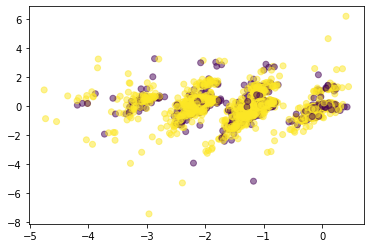

In [140]:
plotFunction(z, df_worthy_train["class_label"])

### Best K

In [141]:
def findBestK(initial, step):
    #TODO use the getVarianceRatio to find the best K
    ratio = np.inf
    while ratio > 0.001:
        initial += step
        z = getKComponents(U, X, initial)
        ratio = getVarianceRatio(z, U, X, initial)
    return initial

In [142]:
step = 543
initial = 1
optimalK = findBestK(initial, step)
optimalK

4888

In [143]:
z = getKComponents(U, X, optimalK)

### TSNE

In [144]:
from sklearn.manifold import TSNE
tsne_pca_results = TSNE(n_components=2, learning_rate="auto", init="random").fit_transform(z)

In [145]:
tsne_pca_results

array([[-0.33142504, -1.6859587 ],
       [ 0.30722678, -5.309812  ],
       [ 5.5576324 ,  4.7978697 ],
       ...,
       [ 5.2393527 ,  2.4977007 ],
       [ 2.1296563 ,  2.6234798 ],
       [ 1.4599026 ,  1.4497721 ]], dtype=float32)

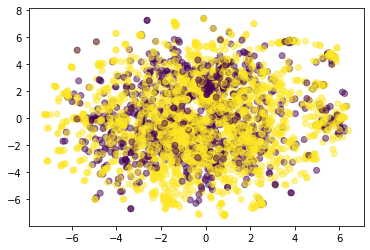

In [146]:
plotFunction(tsne_pca_results, df_worthy_train["class_label"])